#Detección de fraudes con tarjetas de crédito
###Transacciones anónimas con tarjeta de crédito etiquetadas como fraudulentas o auténticas

Es importante que las empresas de tarjetas de crédito sean capaces de reconocer las transacciones fraudulentas con tarjeta de crédito para que no se carguen a los clientes artículos que no compraron.
El conjunto de datos contiene transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeos.
Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284.807 transacciones. El conjunto de datos está muy desequilibrado, la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Sólo contiene variables de entrada numéricas que son el resultado de una transformación PCA (El PCA es una técnica estadística para reducir la dimensionalidad de un conjunto de datos.). Lamentablemente, por motivos de confidencialidad, no podemos facilitar las características originales ni más información sobre los datos. Las características V1, V2, ... V28 son los componentes principales obtenidos con PCA, las únicas características que no han sido transformadas con PCA son 'Tiempo' e 'Importe'. La característica "Tiempo" contiene los segundos transcurridos entre cada transacción y la primera transacción del conjunto de datos. La función "Importe" es el importe de la transacción y puede utilizarse para el aprendizaje sensible a los costes en función del ejemplo. La característica "Clase" es la variable de respuesta y toma el valor 1 en caso de fraude y 0 en caso contrario.

Objetivo: Dado que estamos tratando con un conjunto de datos altamente desequilibrado, donde las transacciones fraudulentas representan una pequeña fracción de todas las transacciones, y se busque minimizar los falsos negativos, es decir, la capacidad para atrapar la mayoria de los fraudes, sin dejar muchos sin detectar ¿cómo medirías la capacidad de nuestro modelo?

In [1]:
#carga de los datos
import gdown

# Define el enlace compartido de Google Drive
url = 'https://drive.google.com/uc?id=1hga3zUzjhYqmR_aCpSIhYEktqClCIaV8'

# Especifica la ubicación donde deseas guardar el archivo
output = '/content/creditcard.csv'  # Cambia 'nombre_de_tu_archivo.csv' según prefieras

# Descarga el archivo desde el enlace compartido
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1hga3zUzjhYqmR_aCpSIhYEktqClCIaV8
To: /content/creditcard.csv
100%|██████████| 151M/151M [00:05<00:00, 26.7MB/s]


'/content/creditcard.csv'

In [2]:
#librerias
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import Dense, Dropout
from keras.models import Sequential



In [3]:
#Procesamiento de los datos
from imblearn.over_sampling import RandomOverSampler

# Divide los datos en características (X) y etiquetas (y)
data = pd.read_csv(output)
X = data.drop('Class', axis=1)
y = data['Class']

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escala las características para normalizar
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Aplicar oversampling utilizando RandomOverSampler
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X, y)


0    284315
1    284315
Name: Class, dtype: int64


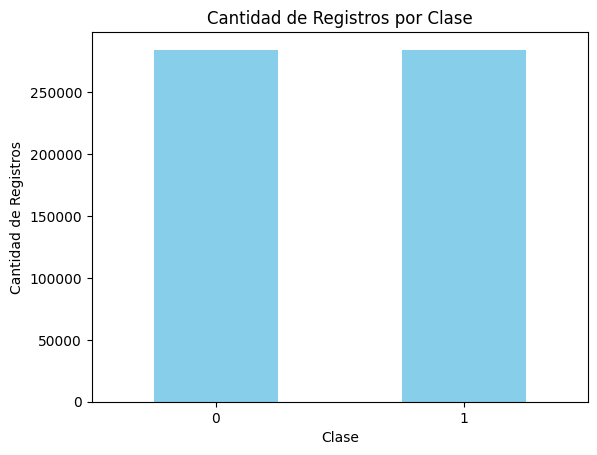

In [4]:
# Imprimir gráfico de barras con la cantidad de registros por clase

print(pd.Series(y_train_resampled).value_counts())
pd.Series(y_train_resampled).value_counts().plot(kind='bar', color='skyblue')
plt.title('Cantidad de Registros por Clase')
plt.xlabel('Clase')
plt.ylabel('Cantidad de Registros')
plt.xticks(rotation=0)
plt.show()

In [5]:
# Define the metrics for the neural network
precision = tf.keras.metrics.Precision(name='precision')
recall = tf.keras.metrics.Recall(name='recall')

#creacion de la red neuronal y entrenamiento
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

# Compilar el modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics= ['accuracy', precision, recall])
callback = EarlyStopping(monitor='loss', mode='min', patience=20)
# Entrenar el modelo
history = model.fit(X_train_resampled, y_train_resampled, epochs=100, batch_size=512, callbacks=[callback])



Epoch 1/100
1111/1111 [==============================] - 7s 5ms/step - loss: 45.2079 - accuracy: 0.5892 - precision: 0.5887 - recall: 0.5916
Epoch 2/100
1111/1111 [==============================] - 4s 4ms/step - loss: 11.4788 - accuracy: 0.7019 - precision: 0.6942 - recall: 0.7216
Epoch 3/100
1111/1111 [==============================] - 5s 5ms/step - loss: 4.1713 - accuracy: 0.7755 - precision: 0.7662 - recall: 0.7930
Epoch 4/100
1111/1111 [==============================] - 5s 4ms/step - loss: 2.0825 - accuracy: 0.8121 - precision: 0.8041 - recall: 0.8252
Epoch 5/100
1111/1111 [==============================] - 4s 4ms/step - loss: 2.0362 - accuracy: 0.8180 - precision: 0.8110 - recall: 0.8293
Epoch 6/100
1111/1111 [==============================] - 6s 5ms/step - loss: 1.4128 - accuracy: 0.8480 - precision: 0.8455 - recall: 0.8517
Epoch 7/100
1111/1111 [==============================] - 4s 4ms/step - loss: 0.9238 - accuracy: 0.8684 - precision: 0.8688 - recall: 0.8678
Epoch 8/100
1111/1

dict_keys(['loss', 'accuracy', 'precision', 'recall'])


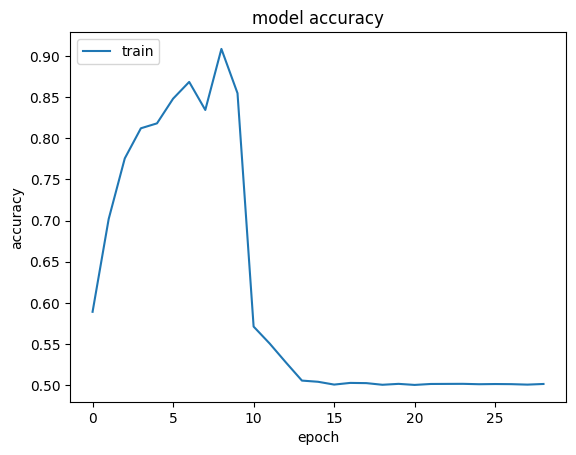

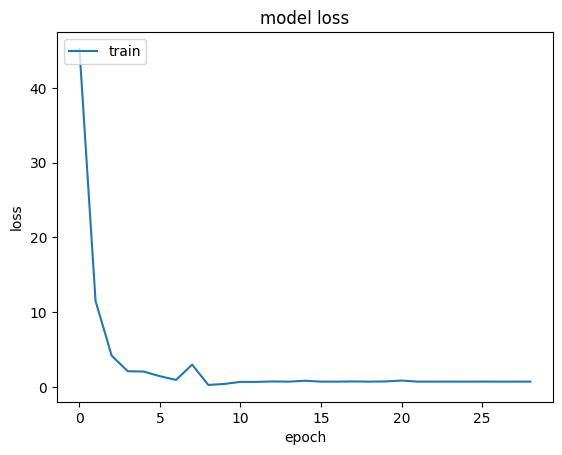

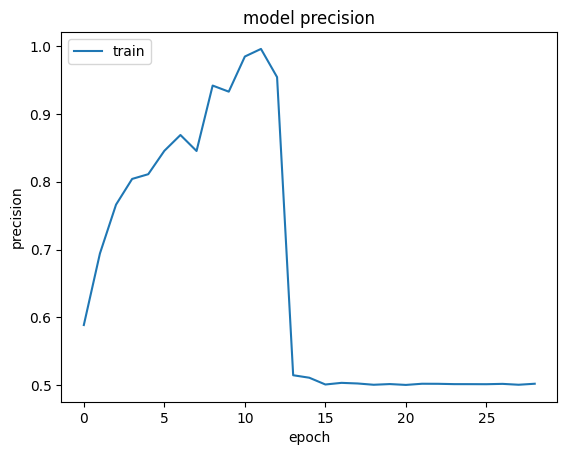

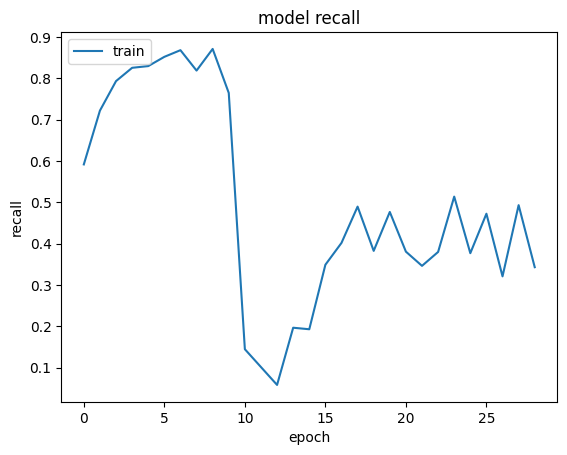

In [6]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for precision
plt.plot(history.history['precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for recall
plt.plot(history.history['recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [7]:
# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convierte las probabilidades en etiquetas binarias (0 o 1)


# Calcula la matriz de confusión (usando "y_test" y "y_pred")
conf_matrix = confusion_matrix(y_test, y_pred)

# Nombres de clases
class_names = ['No', 'Yes']

# Estilizar la matriz de confusión con pandas
conf_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Mostrar la matriz de confusión estilizada
print("\nMatriz de Confusión:")
print(conf_df)


1781/1781 [==============================] - 2s 1ms/step

Matriz de Confusión:
        No   Yes
No   55634  1230
Yes     16    82


### Precision Y Sensibilidad

In [8]:
#Aplicar Presicion como metrica para medir el rendimiento del modelo
# Obtener los valores de la matriz de confusión
TN, FP, FN, TP = conf_matrix.ravel()

# Calcular la precisión
precision = TP / (TP + FP)

print("Precisión:", precision)

# Calcular la sensibilidad (recall)
sensibilidad = TP / (TP + FN)

print("Sensibilidad (Recall):", sensibilidad)

Precisión: 0.0625
Sensibilidad (Recall): 0.8367346938775511


### F1 Score

In [9]:
TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

precision = TP / (TP + FP)
sensitivity = TP / (TP + FN)

f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print("F1-score:", f1)

F1-score: 0.11631205673758865


In [10]:
# Guardamos la arquitectura del modelo entrenado en un archivo json
model_json = model.to_json()
with open("overS-model.json","w") as json_file:
  json_file.write(model_json)